
<div align='left' style="width:400px;height:120px;overflow:hidden;">
<a href='http://www.uff.br'>
<img align='left' style='display: block;height: 92%' src='imgs/UFF.png' alt='UFF logo' title='UFF logo'/>
</a>
<a href='http://www.ic.uff.br'>
<img align='left' style='display: block;height: 100%' src='imgs/logo-ic.png' alt='IC logo' title='IC logo'/>
</a>
</div>

### Machine Learning
# Assessment and Parameter Optimization

### [Luis Martí](http://lmarti.com)
#### [Instituto de Computação](http://www.ic.uff)
#### [Universidade Federal Fluminense](http://www.uff.br)
$\newcommand{\vec}[1]{\boldsymbol{#1}}$

In [3]:
import random, itertools, math
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

In [4]:
import seaborn
seaborn.set(style='whitegrid')
seaborn.set_context('paper')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
# fixing a seed for reproducibility, do not do this in real life. 
random.seed(a=42)
np.random.seed(seed=42)

### About the notebook/slides

* The slides are _programmed_ as a [Jupyter](http://jupyter.org)/[IPython](https://ipython.org/) notebook.
* **Feel free to try them and experiment on your own by launching the notebooks.**

* You can run the notebook online: [![Binder](http://mybinder.org/badge.svg)](http://mybinder.org/repo/lmarti/machine-learning)

If you are using [nbviewer](http://nbviewer.jupyter.org) you can change to slides mode by clicking on the icon:

<div class="container-fluid">
  <div class="row">
      <div class="col-md-3"><span/></div>
      <div class="col-md-6">
      <div class='well well-sm'>
              <img src='imgs/view-as-slides.png'/>
      </div>
      </div>
      <div class="col-md-3" align='center'><span/></div>
  </div>
</div>

# Measuring model error

* The primary goal should be to make a model that most accurately predicts the desired target value for new data. 
* The measure of model error that is used should be one that achieves this goal. 
* However, many modelers instead report a measure of model error that is based not on the error for new data but instead on the error the very same data that was used to train the model. 
* The use of this incorrect error measure can lead to the selection of an inferior and inaccurate model.

# Model quality metrics

Along the course we have presented several quality metrics:

* Regression: mean squared error, mean absolute error, explained variance and R2 score.
* Classification: accuracy, recall, precision, and many more.

But we need more than that to be able to produce valid results.

# Training bias

It is helpful to illustrate this fact with an equation:
* a relationship between how well a model predicts on new data (its true prediction error and the thing we really care about) and 
* how well it predicts on the training data (which is what many modelers in fact measure).

$$
\text{True Prediction Error}=\text{Training Error}+\text{Training Optimism}\,.
$$
where,
* *Training Optimism* is a measure of how much worse our model does on new data compared to the training data.

It turns out that the optimism is a function of model complexity: **complexity increases so does optimism**. 

Thus we have a our relationship above for true prediction error becomes something like this:

$$
\text{True Prediction Error}=\text{Training Error}+f(\text{Model Complexity})\,.
$$

As model complexity increases (for instance by adding parameters terms in a linear regression) the model will always do a better job fitting the training data.

In [6]:
def f(size):
    'Returns a noiseless sample with `size` instances.'
    x = np.linspace(0, 4.5, size)
    y = 2 * np.sin(x * 1.5)
    return x, y

In [7]:
def sample(size):
    'Returns a noisy sample with `size` instances.'
    x, y = f(size)
    return x, y + np.random.randn(x.size)

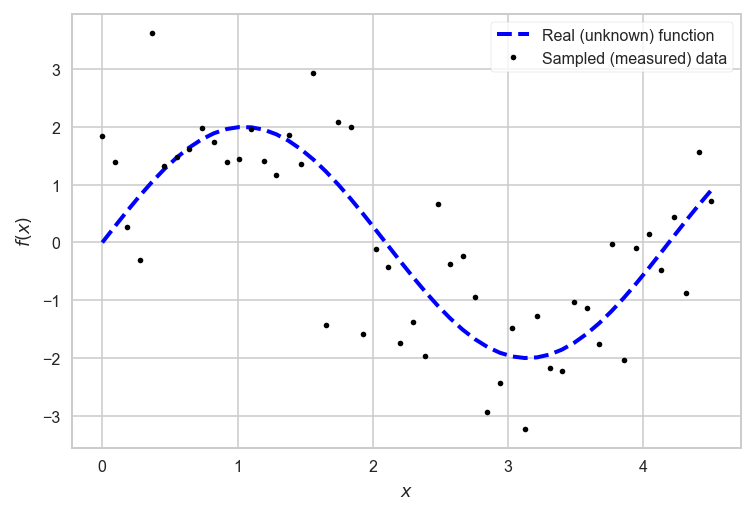

In [25]:
f_x, f_y = f(50)
plt.plot(f_x, f_y, 'b--', linewidth=2, label='Real (unknown) function')
x, y = sample(50)
plt.plot(x, y, 'k.', label='Sampled (measured) data')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend(frameon=True)

# Linear model fitting

We will use least square regression (LSR) to fit a polynomial to the data. 
Actually, we will use **multivariate linear regression**, over a dataset built in the following way:

For each sample $x_{i}$ we build a vector $(1 , x_{i} , x_{i}^{2} , \ldots , x_{i}^{n})$  and we use LSR to fit a function $g:\mathbb{R}^{n+1}\rightarrow\mathbb{R}$ to the training data.

In [26]:
# This illustrates how vander function works:
x1 = np.array([1,2,3])
print(np.vander(x1, 4))

[[ 1  1  1  1]
 [ 8  4  2  1]
 [27  9  3  1]]


In [27]:
from sklearn.linear_model import LinearRegression

In [28]:
def fit_polynomial(x, y, degree):
    '''
    Fits a polynomial to the input sample.
    (x,y): input sample
    degree: polynomial degree
    '''
    model = LinearRegression()
    model.fit(np.vander(x, degree + 1), y)
    return model

In [29]:
def apply_polynomial(model, x):
    '''
    Evaluates a linear regression model in an input sample
    model: linear regression model
    x: input sample
    '''
    degree = model.coef_.size - 1
    y = model.predict(np.vander(x, degree + 1))
    return y

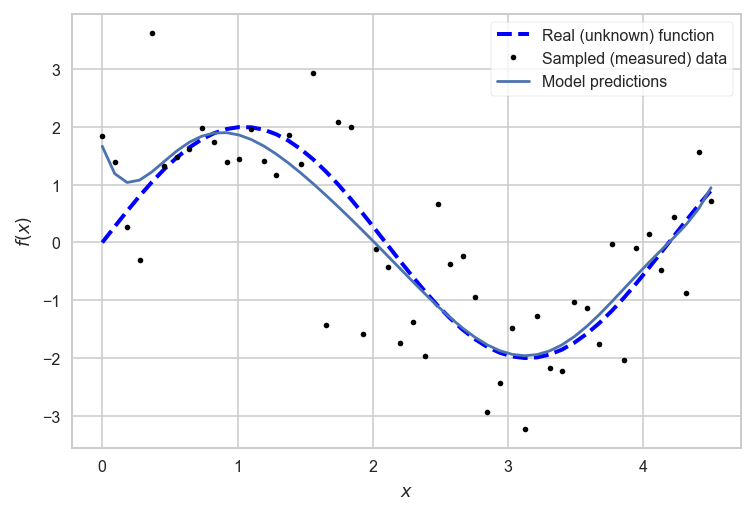

In [30]:
model = fit_polynomial(x, y, 8)
p_y = apply_polynomial(model, x)
plt.plot(f_x, f_y, 'b--', linewidth=2, label='Real (unknown) function')
plt.plot(x, y, 'k.', label='Sampled (measured) data')
plt.plot(x, p_y, label='Model predictions')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend(frameon=True)

Sensitivity to samples

Model averaging
---------------

The following code generates a set of samples of the same size and fits a poynomial to each sample. Then the average model is calculated. All the models, including the average model, are plotted.

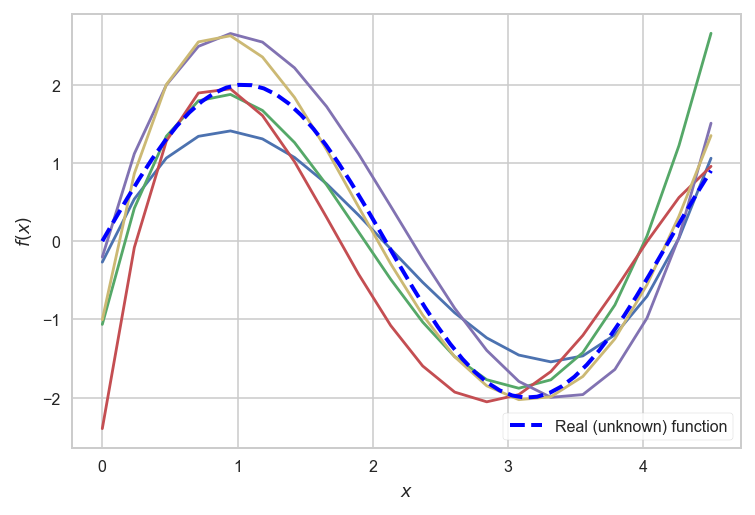

In [31]:
degree = 4
n_samples = 20
n_models = 5
for i in range(n_models):
    x, y = sample(n_samples)
    model = fit_polynomial(x, y, degree)
    p_y = apply_polynomial(model, x)
    plt.plot(x, p_y)
plt.plot(f_x, f_y, 'b--', linewidth=2, label='Real (unknown) function')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend(frameon=True)

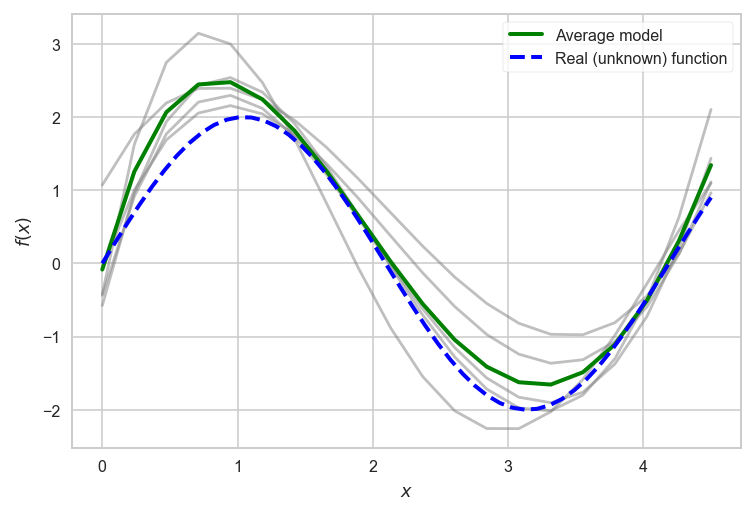

In [33]:
degree = 4
n_samples = 20
n_models = 5
avg_y = np.zeros(n_samples)
for i in range(n_models):
    (x,y) = sample(n_samples)
    model = fit_polynomial(x, y, degree)
    p_y = apply_polynomial(model, x)
    avg_y = avg_y + p_y
    plt.plot(x, p_y, c='gray', alpha=0.5)
avg_y = avg_y / n_models
plt.plot(x, avg_y, 'g-', linewidth=2, label='Average model')
plt.plot(f_x, f_y, 'b--', linewidth=2, label='Real (unknown) function')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend(frameon=True)

Calculating bias and variance
-----------------------------

Same as previous example, we generate several samples and fit a polynomial to each one. We calculate bias an variance among models for different polynomial degrees. Bias, variance and error are plotted against different degree values.

In [34]:
n_samples = 20
f_x, f_y = f(n_samples)
n_models = 100
max_degree = 15

In [37]:
var_vals = []
bias_vals = []
error_vals = []
for degree in range(1, max_degree):
    avg_y = np.zeros(n_samples)
    models = []
    for i in range(n_models):
        x, y = sample(n_samples)
        model = fit_polynomial(x, y, degree)
        p_y = apply_polynomial(model, x)
        avg_y = avg_y + p_y
        models.append(p_y)
    avg_y = avg_y / n_models
    bias_2 = np.linalg.norm(avg_y - f_y) / f_y.size
    bias_vals.append(bias_2)
    variance = 0
    for p_y in models:
        variance += np.linalg.norm(avg_y - p_y)
    variance /= f_y.size * n_models
    var_vals.append(variance)
    error_vals.append(variance + bias_2)

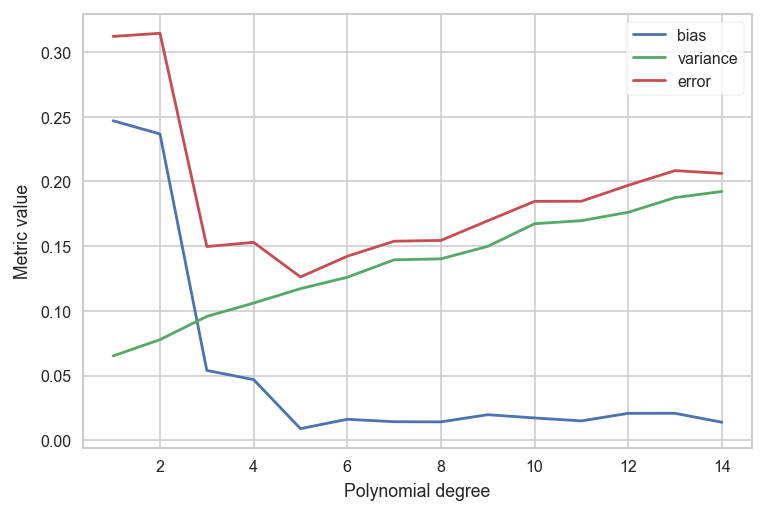

In [38]:
plt.plot(range(1, max_degree), bias_vals, label='bias')
plt.plot(range(1, max_degree), var_vals, label='variance')
plt.plot(range(1, max_degree), error_vals, label='error')
plt.xlabel('Polynomial degree')
plt.ylabel('Metric value')
plt.legend(frameon=True)

<div class="container-fluid">
  <div class="row">
      <div class="col-md-3"><span/></div>
      <div class="col-md-6">
              <img src='http://scott.fortmann-roe.com/docs/docs/MeasuringError/ModelError.png'/>
      </div>
      <div class="col-md-3" align='center'><span/></div>
  </div>
</div>

The simplest of these techniques is the holdout set method.

* Split data into two groups. 
* one group will be used to train the model; the second group will be used to measure the resulting model's error. For instance, if we had 1000 observations, we might use 700 to build the model and the remaining 300 samples to measure that model's error.

<div class="container-fluid">
  <div class="row">
      <div class="col-md-3"><span/></div>
      <div class="col-md-6">
              <img src='http://scott.fortmann-roe.com/docs/docs/MeasuringError/holdout.png'/>
      </div>
      <div class="col-md-3" align='center'><span/></div>
  </div>
</div>

Using the digits dataset for in a holdout case.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm

In [5]:
digits = datasets.load_digits()

In [6]:
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.4)

In [7]:
X_train.shape, y_train.shape

((1078, 64), (1078,))

In [8]:
X_test.shape, y_test.shape

((719, 64), (719,))

Using a support vector classifier to deal with the digits problem.

In [63]:
clf = svm.SVC(kernel='linear', C=0.01).fit(X_train, y_train)

In [65]:
clf.score(X_test, y_test)

0.97886540600667404

When evaluating different settings (hyper-parameters) for estimators, such as the $C$ setting that must be manually set for an SVM, there is still a risk of **overfitting** on the test set because the parameters can be tweaked until the estimator performs optimally. 

This way, knowledge about the test set can "leak" into the model and evaluation metrics no longer report on generalization performance. 

To solve this problem, yet another part of the dataset can be held out as a so-called **validation set**: training proceeds on the training set, after which evaluation is done on the validation set, and when the experiment seems to be successful, final evaluation can be done on the test set.


# Cross-validation

* A solution to this problem is a procedure called cross-validation. 
* A test set should still be held out for final evaluation, but the validation set is no longer needed when doing CV. 

In the basic approach, called $k$-fold cross-validation:
* the training set is split into $k$ train/test sets.
* model is trained using $k-1$ of the folds as training data;
* the resulting model is validated on the remaining part of the data (i.e., it is used as a test set to compute a performance measure such as accuracy).

<div class="container-fluid">
  <div class="row">
      <div class="col-md-3"><span/></div>
      <div class="col-md-6">
              <img src='http://scott.fortmann-roe.com/docs/docs/MeasuringError/crossvalidation.png'/>
      </div>
      <div class="col-md-3" align='center'><span/></div>
  </div>
</div>

Let's apply cross-validation to our previous experiment.

In [11]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

In [12]:
clf = svm.SVC(kernel='linear', C=0.01)

In [13]:
scores = cross_val_score(clf, digits.data, digits.target, cv=5)

In [14]:
scores

array([ 0.96428571,  0.92265193,  0.96657382,  0.9719888 ,  0.92957746])

In [15]:
'Accuracy: {0:2f} (± {1:2f})'.format(scores.mean(), scores.std() * 2)

'Accuracy: 0.951016 (± 0.041203)'

By default, the score computed at each CV iteration is the score method of the estimator. It is possible to change this by using the scoring parameter:

In [16]:
scores = cross_val_score(clf, digits.data, digits.target, cv=5, scoring='f1_macro')

In [17]:
scores

array([ 0.96439803,  0.9219161 ,  0.96592476,  0.97173493,  0.92962078])

# What happens when we want to compare different models?

In [18]:
clf_lin = svm.SVC(kernel='linear', C=0.005).fit(X_train, y_train)

In [19]:
clf_rbf = svm.SVC(kernel='rbf', C=0.005).fit(X_train, y_train)

In [20]:
clf_poly = svm.SVC(kernel='poly', C=0.005).fit(X_train, y_train)

In [21]:
scores_lin = cross_val_score(clf_lin, digits.data, digits.target, scoring='accuracy', cv=20)
scores_rbf = cross_val_score(clf_rbf, digits.data, digits.target, scoring='accuracy', cv=20)
scores_poly = cross_val_score(clf_poly, digits.data, digits.target, scoring='accuracy', cv=20)

In [22]:
scores_lin, scores_rbf, scores_poly

(array([ 0.92631579,  0.97849462,  0.98901099,  1.        ,  0.97777778,
         0.96666667,  0.94444444,  0.97777778,  0.94444444,  0.96666667,
         1.        ,  1.        ,  0.95555556,  0.97777778,  0.98876404,
         1.        ,  0.98876404,  0.92045455,  0.97701149,  0.97674419]),
 array([ 0.10526316,  0.10752688,  0.16483516,  0.1       ,  0.1       ,
         0.1       ,  0.1       ,  0.1       ,  0.1       ,  0.1       ,
         0.1       ,  0.1       ,  0.1       ,  0.1       ,  0.1011236 ,
         0.1011236 ,  0.1011236 ,  0.10227273,  0.10344828,  0.10465116]),
 array([ 0.94736842,  0.98924731,  1.        ,  1.        ,  0.98888889,
         0.97777778,  0.98888889,  1.        ,  1.        ,  0.97777778,
         1.        ,  1.        ,  0.97777778,  0.98888889,  1.        ,
         0.98876404,  1.        ,  0.94318182,  0.97701149,  0.97674419]))

Representing results in a more readable way.

In [66]:
import pandas as pd

In [67]:
data = pd.DataFrame(data=np.vstack((scores_lin, scores_rbf, scores_poly))).T
data.columns = ('Linear', 'Radial', 'Polynomial')

In [68]:
data.head()

,Linear,Radial,Polynomial
0,0.926316,0.105263,0.947368
1,0.978495,0.107527,0.989247
2,0.989011,0.164835,1.000000
3,1.000000,0.100000,1.000000
4,0.977778,0.100000,0.988889


Analyzing the results: Tabular form.

In [26]:
data.describe()

,Linear,Radial,Polynomial
count,20.000000,20.000000,20.000000
mean,0.972834,0.104568,0.986116
std,0.023790,0.014351,0.016711
min,0.920455,0.100000,0.943182
25%,0.963889,0.100000,0.977778
50%,0.977778,0.100000,0.988889
75%,0.988826,0.102567,1.000000
max,1.000000,0.164835,1.000000


Analyzing the results: Graphical form.

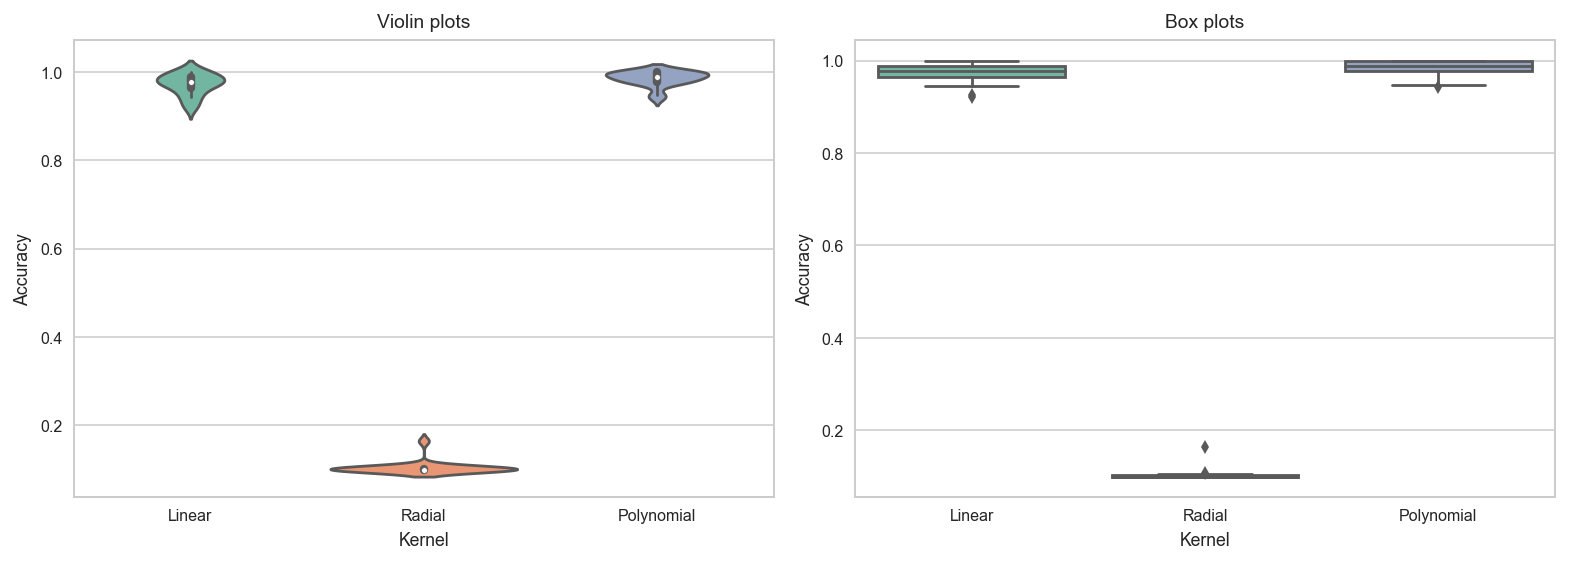

In [27]:
fig = plt.figure(figsize=(11,4))
plt.subplot(121, title='Violin plots')
seaborn.violinplot(data=data, palette='Set2')
plt.ylabel('Accuracy'); plt.xlabel('Kernel')
plt.subplot(122, title='Box plots')
seaborn.boxplot(data=data, palette='Set2')
plt.ylabel('Accuracy'); plt.xlabel('Kernel')
plt.tight_layout()

* Choosing the correct statistical test is essential to properly report the results.
* [Nonparametric statistics](http://en.wikipedia.org/wiki/Nonparametric_statistics) can lend a helping hand.
* [Parametric statistics](http://en.wikipedia.org/wiki/Parametric_statistics) could be a better choice in some cases. 
* Parametric statistics require that *all* data follow a known distribution (frequently a normal one).
* Some tests -like the [normality test](http://en.wikipedia.org/wiki/Normality_test)- can be apply to verify that data meet the parametric stats requirements.
* In my experience that is very unlikely that all your result meet those characteristics.

The [Kruskal-Wallis H-test](http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.kruskal.html) tests the null hypothesis that the population median of all of the groups are equal.

* It is a non-parametric version of [ANOVA](http://en.wikipedia.org/wiki/Analysis_of_variance). 
* The test works on 2 or more independent samples, which may have different sizes. 
* Note that rejecting the null hypothesis does not indicate which of the groups differs. 
* Post-hoc comparisons between groups are required to determine which groups are different.

In [28]:
import scipy.stats as stats

In [29]:
stats.kruskal(*[data[col] for col in data.columns])

KruskalResult(statistic=41.713198148618517, pvalue=8.7517340303375917e-10)

We now can assert that the results are not the same but...
* ...which ones are different or similar to the others the others?

In case that the null hypothesis of the Kruskal-Wallis is rejected the Conover–Inman procedure (Conover, 1999, pp. 288-290) can be applied in a pairwise manner in order to determine if the results of one algorithm were significantly better than those of the other.

* Conover, W. J. (1999). *Practical Nonparametric Statistics*. John Wiley & Sons, New York, 3rd edition.

In [30]:
def conover_inman_procedure(data, alpha=0.05):
    num_runs = len(data)
    num_algos = len(data.columns)
    N = num_runs*num_algos

    _,p_value = stats.kruskal(*[data[col] for col in data.columns])
    
    ranked =  stats.rankdata(np.concatenate([data[col] for col in data.columns]))
    
    ranksums = []
    for i in range(num_algos):
        ranksums.append(np.sum(ranked[num_runs*i:num_runs*(i+1)]))

    S_sq = (np.sum(ranked**2) - N*((N+1)**2)/4)/(N-1)

    right_side = stats.t.cdf(1-(alpha/2), N-num_algos) * \
                 math.sqrt((S_sq*((N-1-p_value)/(N-1)))*2/num_runs)
    
    res = pd.DataFrame(columns=data.columns, index=data.columns)

    for i,j in itertools.combinations(np.arange(num_algos),2):
        res[res.columns[i]].iloc[j] = abs(ranksums[i] - ranksums[j]/num_runs) > right_side
        res[res.columns[j]].iloc[i] = abs(ranksums[i] - ranksums[j]/num_runs) > right_side
    return res

In [31]:
conover_inman_procedure(data)

,Linear,Radial,Polynomial
Linear,NaN,True,True
Radial,True,NaN,True
Polynomial,True,True,NaN


## But... how to properly set the hyper-parameters

* Hyper-parameters are parameters that are not directly learned within estimators.
* Typical examples include $C$, kernel and $\gamma$ for support vector classifiers, learning rate for neural networks, etc.

In order to do this search we need:
* an estimator (regressor or classifier such as `sklearn.svm.SVC()`);
* a parameter space that specifies what set of values the hyper-parameters take;
* a method for searching or sampling candidates;
* a cross-validation scheme; and
* a score function.

# Grid search

The traditional way of performing hyper-parameter optimization has been *grid search* , or *parameter sweep*.
* An exhaustive searching through a manually specified subset of the hyper-parameter space of a learning algorithm. 
* Must be guided by some performance metric, typically measured by cross-validation on the training set or evaluation on a held-out validation set.

Let's program an example of using grid search. Using SVCs again, but with a more complex problem: digits.

Loading and preparing the dataset:

In [69]:
digits = datasets.load_digits()
n_samples = len(digits.images)
X = digits.images.reshape((n_samples, -1))
y = digits.target

We must start by defining our search space:

In [70]:
param_grid = [
  {'C': [0.1, 1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [0.1, 1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
  {'C': [0.1, 1, 10, 100, 1000], 'kernel': ['poly']},
 ]

Split the dataset in two equal parts

Tuning hyper-parameters for **accuracy**

In [71]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from multiprocessing import cpu_count

Preparing the grid search. Note how simple is to make it run in parallel (`n_jobs`).

In [72]:
folds = 30
clf = GridSearchCV(svm.SVC(), param_grid, cv=folds, scoring='accuracy', n_jobs=cpu_count())

In [73]:
clf.fit(X, y)

GridSearchCV(cv=30, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=4,
       param_grid=[{'C': [0.1, 1, 10, 100, 1000], 'kernel': ['linear']}, {'C': [0.1, 1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']}, {'C': [0.1, 1, 10, 100, 1000], 'kernel': ['poly']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [74]:
clf.best_params_

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

In [75]:
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']

In [76]:
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

0.976 (+/-0.043) for {'C': 0.1, 'kernel': 'linear'}
0.976 (+/-0.043) for {'C': 1, 'kernel': 'linear'}
0.976 (+/-0.043) for {'C': 10, 'kernel': 'linear'}
0.976 (+/-0.043) for {'C': 100, 'kernel': 'linear'}
0.976 (+/-0.043) for {'C': 1000, 'kernel': 'linear'}
0.964 (+/-0.068) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
0.907 (+/-0.099) for {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.988 (+/-0.026) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.968 (+/-0.056) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.989 (+/-0.025) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.983 (+/-0.033) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.989 (+/-0.025) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.984 (+/-0.035) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.989 (+/-0.025) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.984 (+/-0.035) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.987 (+/-0.031) for {'C': 0.1, 'kernel': 'poly'}
0.987 (+/-0.031) for {'C': 1, 'kernel': '

In [77]:
scores = [clf.cv_results_['split{0}_test_score'.format(i)] for i in range(folds)]

In [78]:
data = pd.DataFrame(data=scores)
data.columns = ['Case {}'.format(i) for i in range(len(data.columns))]

In [79]:
data.head()

,Case 0,Case 1,Case 2,Case 3,Case 4,Case 5,Case 6,Case 7,Case 8,Case 9,Case 10,Case 11,Case 12,Case 13,Case 14,Case 15,Case 16,Case 17,Case 18,Case 19
0,0.938462,0.938462,0.938462,0.938462,0.938462,0.953846,0.923077,0.969231,0.938462,0.969231,0.953846,0.969231,0.938462,0.969231,0.938462,0.953846,0.953846,0.953846,0.953846,0.953846
1,0.984127,0.984127,0.984127,0.984127,0.984127,0.888889,0.841270,0.984127,0.952381,0.984127,0.984127,0.984127,0.984127,0.984127,0.984127,0.984127,0.984127,0.984127,0.984127,0.984127
2,0.983607,0.983607,0.983607,0.983607,0.983607,0.983607,0.885246,0.983607,0.983607,1.000000,0.983607,1.000000,1.000000,1.000000,1.000000,0.983607,0.983607,0.983607,0.983607,0.983607
3,0.983333,0.983333,0.983333,0.983333,0.983333,1.000000,0.916667,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,1.000000,1.000000,1.000000,1.000000,1.000000,0.983333,0.983333,1.000000,0.983333,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


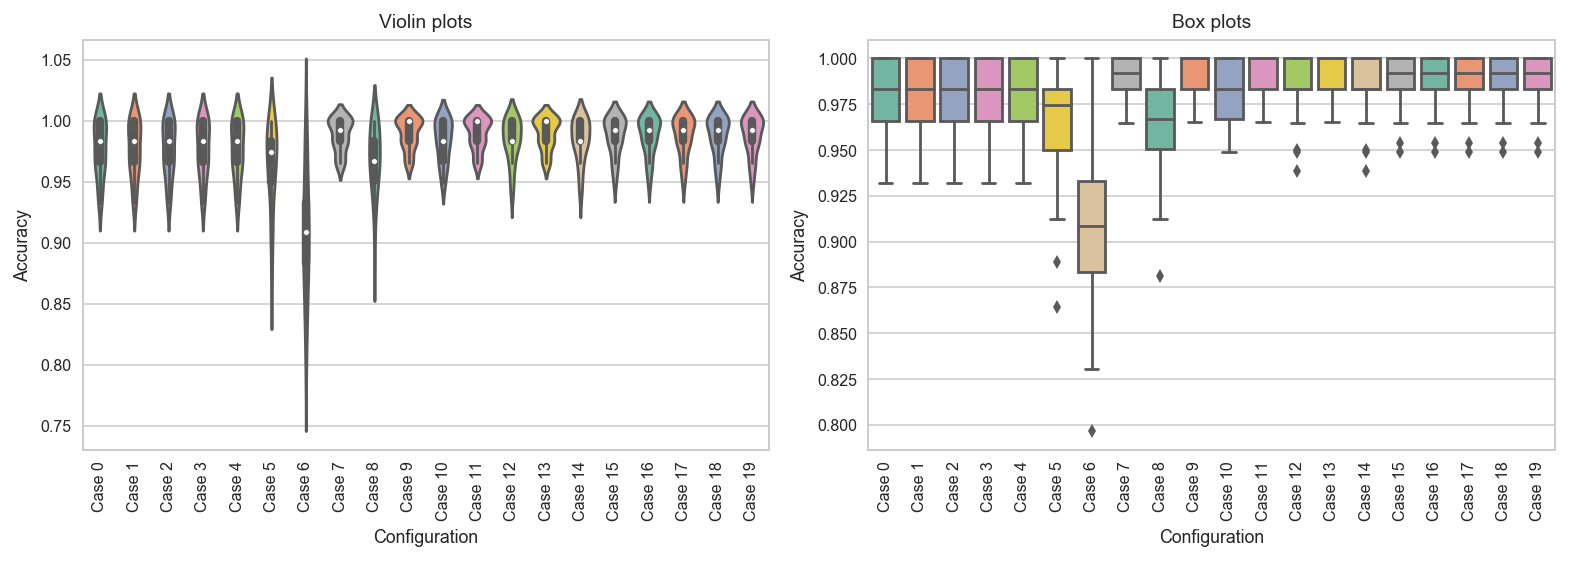

In [80]:
fig = plt.figure(figsize=(11,4))
plt.subplot(121, title='Violin plots')
seaborn.violinplot(data=data, palette='Set2')
plt.ylabel('Accuracy'); plt.xlabel('Configuration'); plt.xticks(rotation=90)
plt.subplot(122, title='Box plots')
seaborn.boxplot(data=data, palette='Set2')
plt.ylabel('Accuracy'); plt.xlabel('Configuration'); plt.xticks(rotation=90)
plt.tight_layout()

# This approach can be improved!

* How to prevent doing exhaustive search? 
* In many dimensions exhaustive search is impossible (NP-hard).
* We may know what areas of the search space are good or bad as the search process goes by.
* Metaheuristic approaches like evolutionary algorithms are the solution.

<hr/>
<div class="container-fluid">
  <div class='well'>
      <div class="row">
          <div class="col-md-3" align='center'>
              <img align='center'alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png"/>
          </div>
          <div class="col-md-9">
              This work is licensed under a [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-nc-sa/4.0/).
          </div>
      </div>
  </div>
</div>
* Part of this notebook uses some materials of the [scikit learn tutorial](https://github.com/jakevdp/sklearn_tutorial/), Copyright (c) 2015, [Jake Vanderplas](http://www.vanderplas.com).

In [48]:
# this code is here for cosmetic reasons
from IPython.core.display import HTML
from urllib.request import urlopen
HTML(urlopen('https://raw.githubusercontent.com/lmarti/jupyter_custom/master/custom.include').read().decode('utf-8'))

--- 